# Installing Dependencies
Before loading the data, we need to install some dependencies that don’t come by default on Anaconda.

In [48]:
!pip install pyjanitor pyvis --quiet

In [49]:
import pandas as pd
import janitor
import datetime

from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx

# Load the Data

This is your 'connections.csv' file you downloaded from LinkedIn - the 'skiprows' allows you to skiprows that are not part of your data.

In [50]:
df_ori = pd.read_csv("./linkedin_data/Connections.csv", skiprows=3) 

In [51]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787 entries, 0 to 786
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     786 non-null    object
 1   Last Name      786 non-null    object
 2   Email Address  20 non-null     object
 3   Company        786 non-null    object
 4   Position       786 non-null    object
 5   Connected On   787 non-null    object
dtypes: object(6)
memory usage: 37.0+ KB


## Data Cleaning

In [52]:
# the dot after each new line, means that over the same dataframe, I apply the same method over and over... 
df = (
    df_ori
    .clean_names() # remove spacing and capitalization
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
    .dropna(subset=['company', 'position']) # drop missing values in company and position
    .to_datetime('connected_on', infer_datetime_format=True)
  )
df.head()

,company,position,connected_on
0,Home365 Property Management,Principal Product Manager,2023-02-14
1,Canter,Founder & Principal,2023-02-07
2,American Express,Finance Manager,2023-02-07
3,Zutto Technologies,Director de nuevos proyectos,2023-02-06
4,Amateur Fund,Investor,2023-02-05


In [53]:

# consolidate the company names within just one name
df['company'] = df['company'].replace(['Babson College', 'Babson F.W. Olin Graduate School of Business'], 'Babson College')

df['company'] = df['company'].replace(['CIFI - Corporación Interamericana para el Financiamiento de Infraestructura, S.A.'], 'CIFI')


## Simple EDA

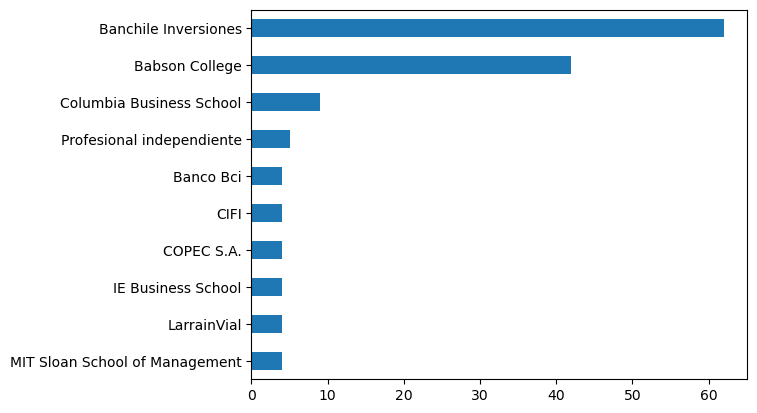

In [54]:
df['company'].value_counts().head(10).plot(kind="barh").invert_yaxis();

In [55]:
#df['company'].value_counts().head(10)


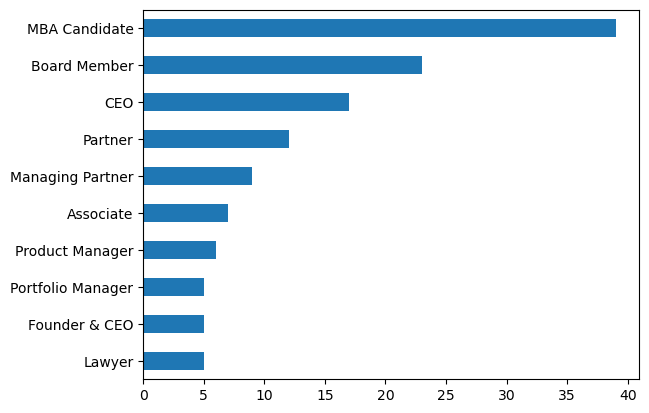

In [56]:
# consolidate some positions with just one name
df['position'] = df['position'].replace(['gerente general', 'Gerente general', 'Gerente General'], 'CEO')
df['position'] = df['position'].replace(['socio', 'Socio'], 'Partner')
df['position'] = df['position'].replace(['Abogado'], 'Lawyer')
df['position'] = df['position'].replace(['Director', 'Director ejecutivo'], 'Board Member')
df['position'].value_counts().head(10).plot(kind="barh").invert_yaxis();

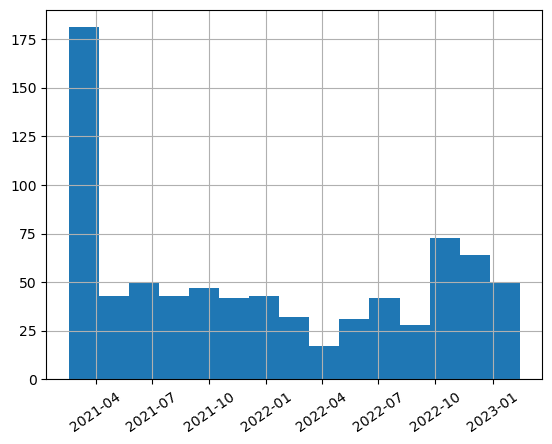

In [57]:
df['connected_on'].hist(xrot=35, bins=15);

### Remove freelance and self-employed titles

In [58]:
pattern = "freelance|self-employed|Profesional independiente"
df = df[~df['company'].str.contains(pattern, case=False)]

## Aggregate sum of connections for companies

In [59]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,Banchile Inversiones,62
1,Babson College,42
2,Columbia Business School,9
6,LarrainVial,4
8,IE Business School,4
7,COPEC S.A.,4
9,MIT Sloan School of Management,4
5,BTG Pactual Chile,4
4,Banco Bci,4
3,CIFI,4


## Aggregate sum of connections for positions

In [60]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,MBA Candidate,39
1,Board Member,22
2,CEO,17
3,Partner,12
4,Managing Partner,9
5,Associate,7
6,Product Manager,6
9,Founder & CEO,5
10,Portfolio Manager,5
8,Founder,5


## Creating the network

In [61]:
print(df_company.shape)
# remove every company that I don't know more than 3 people. 
df_company_reduced = df_company.loc[df_company['count']>=4]
print(df_company_reduced.shape)

(566, 2)
(10, 2)


In [62]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=4]
print(df_position_reduced.shape)

(615, 2)
(13, 2)


In [63]:
# initialize graph for my connections' companies
g = nx.Graph()
g.add_node('Camilo Perez de Arce') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row['company']
  count = row['count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#33ACFF')
  g.add_edge('Camilo Perez de Arce', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
# display(HTML('company_graph.html'))

In [64]:
# initialize graph for my connections' positions
g = nx.Graph()
g.add_node('Camilo Perez de Arce') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

  # store company name and count
  position = row['position']
  count = row['count']

  title = f"<b>{position}</b> – {count}"
  positions = set([x for x in df[position == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(position, size=count*2, title=hover_info, color='#98fb98')
  g.add_edge('Camilo Perez de Arce', position, color='white')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('position_graph.html')
# display(HTML('company_graph.html'))

In [65]:
df['user'] = 'Camilo'
print(df.head(10))

                               company                        position  \
0          Home365 Property Management       Principal Product Manager   
1                               Canter             Founder & Principal   
2                     American Express                 Finance Manager   
3                   Zutto Technologies    Director de nuevos proyectos   
4                         Amateur Fund                        Investor   
5                              KPMG US                         Manager   
6                        .406 Ventures  Venture Capital Student Fellow   
7  Suntory PepsiCo Beverage (Thailand)      Financial Analysis Manager   
8                              Arrived     Co-founder | COO at Arrived   
9          Coordinadora de Tanques SAS    Director Of Customer Service   

  connected_on    user  
0   2023-02-14  Camilo  
1   2023-02-07  Camilo  
2   2023-02-07  Camilo  
3   2023-02-06  Camilo  
4   2023-02-05  Camilo  
5   2023-02-04  Camilo  
6   2023-0

In [66]:
df.to_csv('LinkedIn_Camilo_Data.csv', index=False)